# 1. Импортируем библиотеки и данные

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from torchvision import models, transforms
import albumentations as A
from tqdm import tqdm
# Отключаем проверку
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Получаем список имён файлов
images_special_car = listdir('./Dataset/Spesial_car/') 
image_rest = listdir('./Dataset/Rest/')

# Переносим их в датафрейм
data_special_car = pd.DataFrame(images_special_car, columns=['src'])
data_rest = pd.DataFrame(image_rest, columns=['src'])

# Добавляем целевые признаки
data_special_car['label'] = 1 # Спец. авто
data_rest['label'] = 0 # Простые фотографии

# Объядиняем 
data = pd.concat([data_special_car, data_rest], ignore_index=True)
data # Посмотрим на получившийся датафрейм

,src,label
0,0000.jpg,1
1,0001.jpg,1
2,0002.png,1
3,0003.jpg,1
4,0004.png,1
...,...,...
1090,Men___Male_Celebrity_Movie_star_Zac_Efron_0582...,0
1091,MS_CloseUp-27 (1).jpg,0
1092,MS_CloseUp-27.jpg,0
1093,MV5BMTA4MDIxNjY3MjZeQTJeQWpwZ15BbWU3MDI5Njc4MT...,0


In [3]:
data['label'].value_counts() / data.shape[0] * 100 # Распределение целевого признака

label
0    56.894977
1    43.105023
Name: count, dtype: float64

Можно заметить, что фотографий без спец авто больше в датасете

# 2. Аугментация фотографий и последующая обработка

In [4]:
# Описываем приёмы аугментации
transform1 = A.Compose([
    A.HorizontalFlip(p=0.5), # Отзеркаливание изображения
    A.RandomBrightnessContrast(p=0.2), # Изменение яркости ищображения
])
transform2 = A.Compose([
    A.MedianBlur(p=0.5) # Эффект размытия на изображении
])

100%|██████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:34<00:00, 31.62it/s]


CPU times: total: 12.6 s
Wall time: 37.2 s


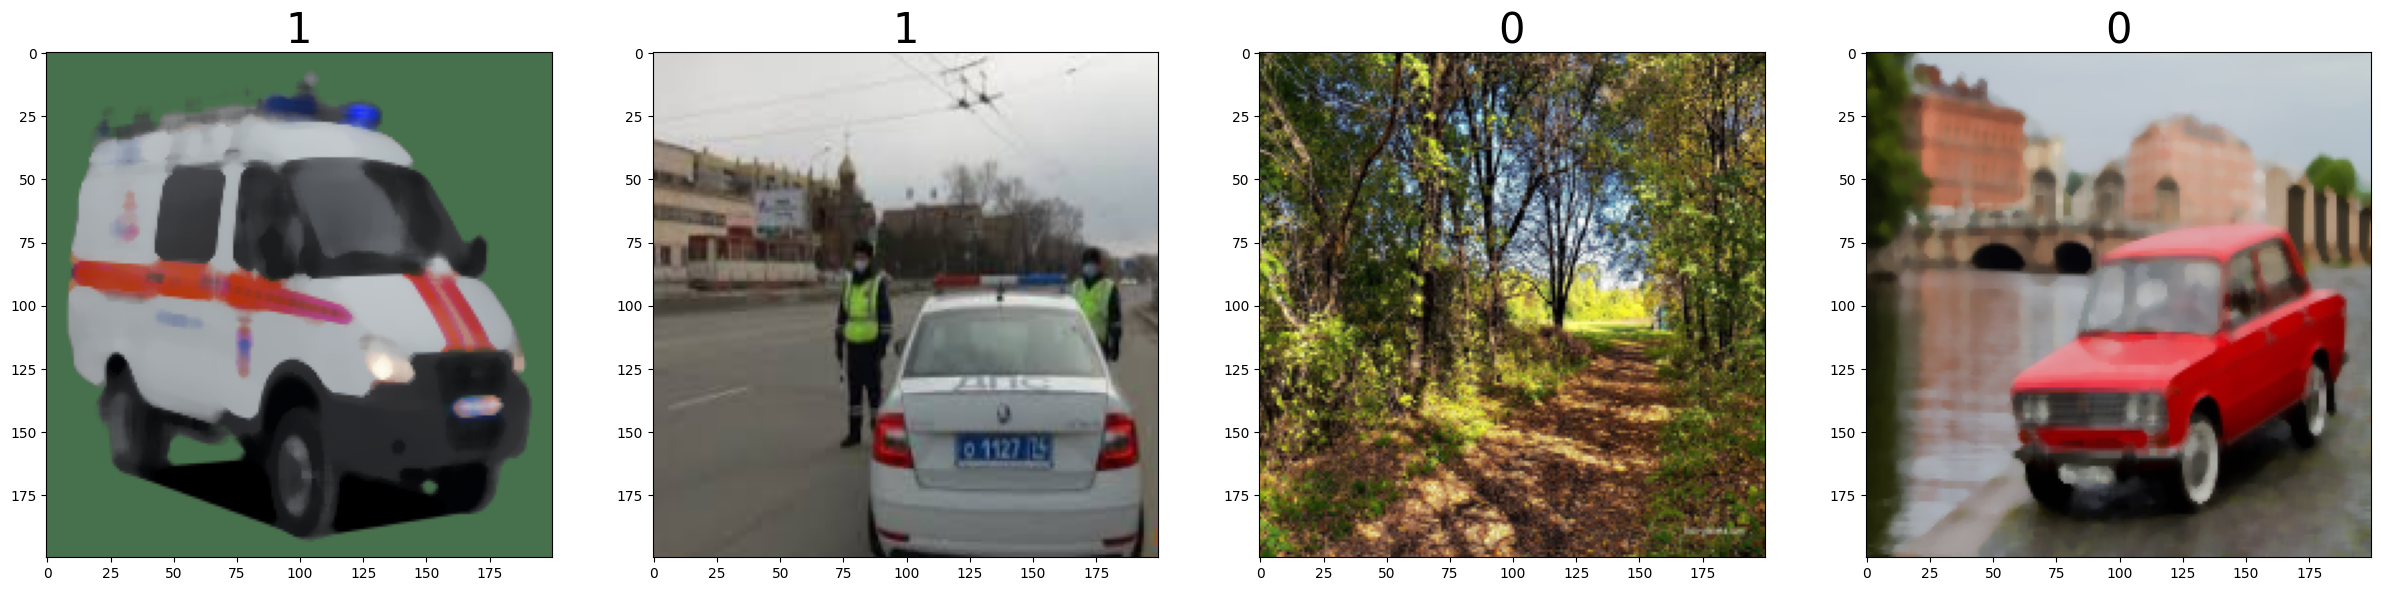

In [5]:
%%time
X = [] # Фотографии в формате матриц
y = [] # Классы фотографий
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Получим путь к изображению
    if (data.loc[i, 'label'] == 1): # Если на фотографии спец. авто
        image = cv2.imread('./Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # Если на фотографии не спец. авто
        image = cv2.imread('./Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Перевеодим цветовую палитру фото с формата BGR в RGB 
    image = cv2.resize(image, dsize=(200, 200), interpolation=cv2.INTER_AREA); # Изменяем размерность изображения до 200x200
    X.append(image) # Добавляем в датасет

    # Производим аугментацию фотографий и добавим в списки
    transformed_image = transform1(image=image)
    X.append(transformed_image["image"])
    transformed_image = transform2(image=image)
    X.append(transformed_image["image"])
    for _ in range(3):
        y.append(data.loc[i, 'label'])

# Нормализируем данные
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3,200,200)
y_torch = np.array(y).reshape(-1)

# Выведем пару примеров получившихся фотографий
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4+14])
    axes[i].set_title(y[i*y_torch.size//4+14], fontsize=30)

In [6]:
print(f"Количество фотографий после аугментации: {y_torch.size}") # кол-во фото

Количество фотографий после аугментации: 3285


С помощь применения методов аугментации получилось величить датасет в 3 раза

# 3. Обучение нейросети
## 3.1. Формирование тренировочной и валидационной выборки, перевод данных в тензоры.

In [7]:
# Определим возможность обработки фото на GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
# Сформируем новую тренировчную и тестовую выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)

In [9]:
# Переведём все данные в тензоры и сформируем "пакеты"
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=31)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)

## 3.2. Тренировка архитектуру нейросети DenseNet121

In [10]:
model = models.densenet121() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1024, 2) # Замена слоя классификации
model.to(device) # Загрузка модели на устройство

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
criterion = torch.nn.CrossEntropyLoss() # Вычесление ошибки
optimizer = torch.optim.Adam(model.parameters()) # Вычесление градиента ошибок
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [12]:
max_epochs = 500
best_model = model # Лучшая модель
last_loss = np.Inf
epoch_erly_stopping = 0
flag = False 
col_not_best = 0 # Количество эпох без изменений
accyracy_best = 0 # Лучшая точность 
accuracy_history = {"train": [], "valid": []}
loss_history = {"train": [], "valid": []}
train_losses = []
valid_losses = []
start_time = datetime.now()
for epoch in range(max_epochs+1):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Переносим на устройсво данные
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() # Обнуляем градиенты ошибок
                outp = model(x_batch) # Получаем ответы от модели
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # Softmax, получаем класс
            correct = (preds == y_batch).sum() # Кол-во правильных ответов
            all = preds.size(0) # Кол-во всех ответов
            epoch_correct += correct.item() # Кол-во фото корректно распознанных
            epoch_all += all # Общее кол-во фото 
            loss = criterion(outp, y_batch) # Вычисляем градиети
            if k == "train":
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            else:
                valid_losses.append(loss.item())
                
        if k == "valid":
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            loss_history["train"].append(train_loss)
            loss_history["valid"].append(valid_loss)
            print(f"[{epoch:>3}/{max_epochs:>3}] loss train: {train_loss:.5f} | loss valid: {valid_loss:.5f}")
            if round(last_loss, 5) > round(valid_loss, 5):
                col_not_best = 0
                best_model = model
                epoch_erly_stopping = epoch
                torch.save(best_model, "checkpoint.pt")
                print(f"Validation loss decreased ({last_loss:.5f} --> {valid_loss:.5f}).  Saving model ...")
                last_loss = valid_loss
            else:
                if col_not_best + 1 >= 20:
                    print("Early stopping!")
                    accuracy_history[k].append(epoch_correct/epoch_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
                    print(f"EarlyStopping counter: {col_not_best} out of 20")                  
        accuracy_history[k].append(epoch_correct/epoch_all)
    if flag:
        break
torch.save(best_model, "model121.pth")
print(f'Program execution time: {datetime.now() - start_time}')

[  0/500] loss train: 0.62828 | loss valid: 0.61707
Validation loss decreased (inf --> 0.61707).  Saving model ...
[  1/500] loss train: 0.57177 | loss valid: 0.55000
Validation loss decreased (0.61707 --> 0.55000).  Saving model ...
[  2/500] loss train: 0.53568 | loss valid: 0.57486
EarlyStopping counter: 1 out of 20
[  3/500] loss train: 0.50518 | loss valid: 0.57992
EarlyStopping counter: 2 out of 20
[  4/500] loss train: 0.48041 | loss valid: 0.55840
EarlyStopping counter: 3 out of 20
[  5/500] loss train: 0.45985 | loss valid: 0.55091
EarlyStopping counter: 4 out of 20
[  6/500] loss train: 0.44004 | loss valid: 0.53265
Validation loss decreased (0.55000 --> 0.53265).  Saving model ...
[  7/500] loss train: 0.42297 | loss valid: 0.54032
EarlyStopping counter: 1 out of 20
[  8/500] loss train: 0.40568 | loss valid: 0.52637
Validation loss decreased (0.53265 --> 0.52637).  Saving model ...
[  9/500] loss train: 0.38955 | loss valid: 0.51310
Validation loss decreased (0.52637 --> 0.

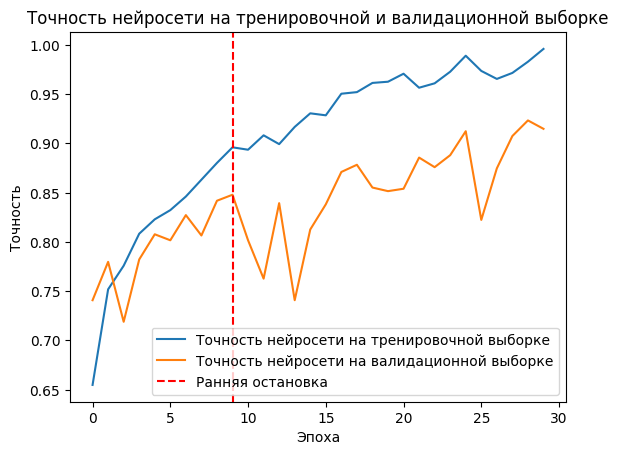

In [13]:
plt.plot(accuracy_history['train'], label='Точность нейросети на тренировочной выборке')
plt.plot(accuracy_history['valid'], label='Точность нейросети на валидационной выборке')
plt.title('Точность нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

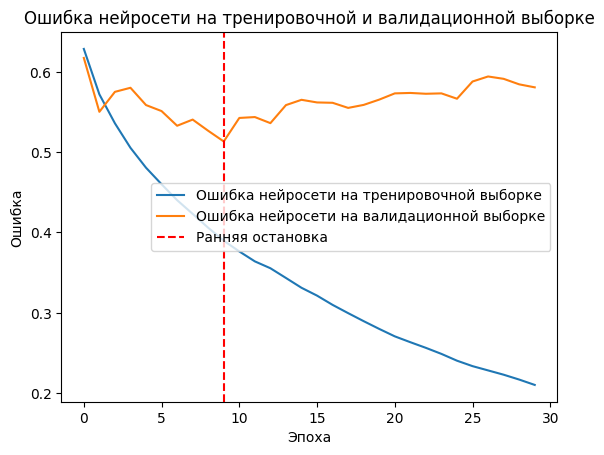

In [14]:
plt.plot(loss_history["train"], label='Ошибка нейросети на тренировочной выборке')
plt.plot(loss_history["valid"], label='Ошибка нейросети на валидационной выборке')
plt.title('Ошибка нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

## 3.3. Тренировка архитектуру нейросети DenseNet169

In [15]:
model = models.densenet169() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1664, 2) # Замена слоя классификации
model.to(device) # Загрузка модели на устройство

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
criterion = torch.nn.CrossEntropyLoss() # Вычесление ошибки
optimizer = torch.optim.Adam(model.parameters()) # Вычесление градиента ошибок
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [17]:
max_epochs = 500
best_model = model # Лучшая модель
last_loss = np.Inf
epoch_erly_stopping = 0
flag = False 
col_not_best = 0 # Количество эпох без изменений
accyracy_best = 0 # Лучшая точность 
accuracy_history = {"train": [], "valid": []}
loss_history = {"train": [], "valid": []}
train_losses = []
valid_losses = []
start_time = datetime.now()
for epoch in range(max_epochs+1):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Переносим на устройсво данные
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() # Обнуляем градиенты ошибок
                outp = model(x_batch) # Получаем ответы от модели
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # Softmax, получаем класс
            correct = (preds == y_batch).sum() # Кол-во правильных ответов
            all = preds.size(0) # Кол-во всех ответов
            epoch_correct += correct.item() # Кол-во фото корректно распознанных
            epoch_all += all # Общее кол-во фото 
            loss = criterion(outp, y_batch) # Вычисляем градиети
            if k == "train":
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            else:
                valid_losses.append(loss.item())
                
        if k == "valid":
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            loss_history["train"].append(train_loss)
            loss_history["valid"].append(valid_loss)
            print(f"[{epoch:>3}/{max_epochs:>3}] loss train: {train_loss:.5f} | loss valid: {valid_loss:.5f}")
            if round(last_loss, 5) > round(valid_loss, 5):
                col_not_best = 0
                best_model = model
                epoch_erly_stopping = epoch
                torch.save(best_model, "checkpoint.pt")
                print(f"Validation loss decreased ({last_loss:.5f} --> {valid_loss:.5f}).  Saving model ...")
                last_loss = valid_loss
            else:
                if col_not_best + 1 >= 20:
                    print("Early stopping!")
                    accuracy_history[k].append(epoch_correct/epoch_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
                    print(f"EarlyStopping counter: {col_not_best} out of 20")                  
        accuracy_history[k].append(epoch_correct/epoch_all)
    if flag:
        break
torch.save(best_model, "model169.pth")
print(f'Program execution time: {datetime.now() - start_time}')

[  0/500] loss train: 0.62893 | loss valid: 0.69164
Validation loss decreased (inf --> 0.69164).  Saving model ...
[  1/500] loss train: 0.57399 | loss valid: 0.63470
Validation loss decreased (0.69164 --> 0.63470).  Saving model ...
[  2/500] loss train: 0.53644 | loss valid: 0.80979
EarlyStopping counter: 1 out of 20
[  3/500] loss train: 0.50736 | loss valid: 0.72274
EarlyStopping counter: 2 out of 20
[  4/500] loss train: 0.48173 | loss valid: 0.68456
EarlyStopping counter: 3 out of 20
[  5/500] loss train: 0.45974 | loss valid: 0.69646
EarlyStopping counter: 4 out of 20
[  6/500] loss train: 0.44648 | loss valid: 0.66181
EarlyStopping counter: 5 out of 20
[  7/500] loss train: 0.42867 | loss valid: 0.62759
Validation loss decreased (0.63470 --> 0.62759).  Saving model ...
[  8/500] loss train: 0.41029 | loss valid: 0.60673
Validation loss decreased (0.62759 --> 0.60673).  Saving model ...
[  9/500] loss train: 0.39327 | loss valid: 0.60757
EarlyStopping counter: 1 out of 20
[ 10/5

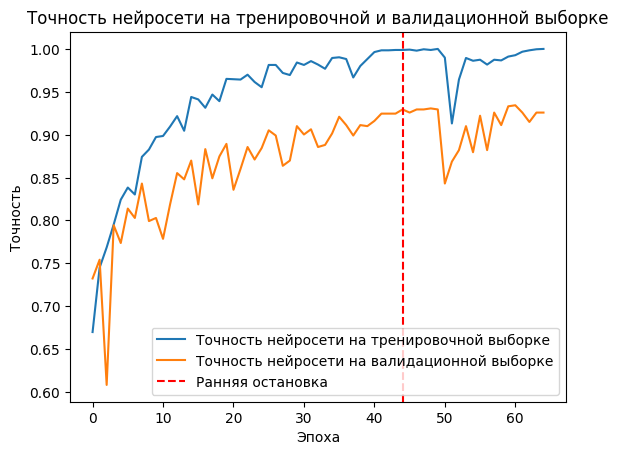

In [18]:
plt.plot(accuracy_history['train'], label='Точность нейросети на тренировочной выборке')
plt.plot(accuracy_history['valid'], label='Точность нейросети на валидационной выборке')
plt.title('Точность нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

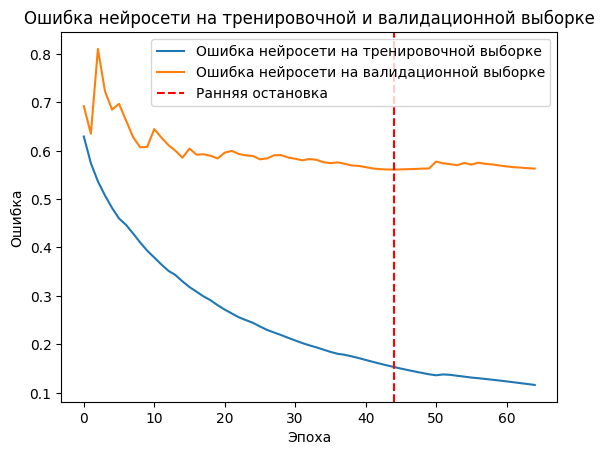

In [19]:
plt.plot(loss_history["train"], label='Ошибка нейросети на тренировочной выборке')
plt.plot(loss_history["valid"], label='Ошибка нейросети на валидационной выборке')
plt.title('Ошибка нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

По итогу обучения двух нейросетей можно сделать следующий вывод:

    DenseNet121 показала точность в 85% и ошибку 0.51310
    DenseNet169 показала точность в 92% и ошибку 0.56057
    Исходя из этих данных было принято решение брать архитектуру DenseNet121 т.к они имеет меньше ошибку на валидационных данных. 

# 4. Просмотр скорости работы нейросетей

In [20]:
%%time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load('model121.pth').to(device)

CPU times: total: 62.5 ms
Wall time: 591 ms


In [21]:
%%time
PATH = './Dataset/Spesial_car/0001.jpg' # Путь к фото
# Загрузка и обработка фото
X = []
src = cv2.imread(PATH, cv2.IMREAD_COLOR) 
dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))
X = np.array(X)
X = X.astype('float32')
X = X / 255.0
X = X.reshape(-1,3,200,200)
X = torch.from_numpy(X).float().to(device)

# Модель ставим на predict и пропускаем
best_model.eval()
print(best_model(X).argmax(-1).item())

1
CPU times: total: 46.9 ms
Wall time: 65.6 ms


In [22]:
%%time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load('model169.pth').to(device)

CPU times: total: 188 ms
Wall time: 267 ms


In [23]:
%%time
PATH = './Dataset/Spesial_car/0003.jpg' # Путь к фото
# Загрузка и обработка фото
X = []
src = cv2.imread(PATH, cv2.IMREAD_COLOR) 
dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))
X = np.array(X)
X = X.astype('float32')
X = X / 255.0
X = X.reshape(-1,3,200,200)
X = torch.from_numpy(X).float().to(device)

# Модель ставим на predict и пропускаем
best_model.eval()
print(best_model(X).argmax(-1).item())

1
CPU times: total: 62.5 ms
Wall time: 89.6 ms
